In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

## Loading and preprocessing CIFAR10

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


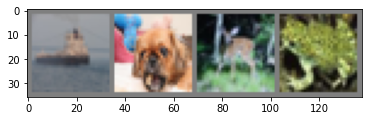

 ship   dog  deer  frog


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images_batch, labels_batch = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images_batch))
# print labels
print(' '.join('%5s' % classes[labels_batch[j]] for j in range(4)))

## Define a Convolutional Neural Network

This particular architecture is called LeNet, developed in 1989 by Yann LeCun.

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define a Loss Function and Optimizer

In [6]:
import torch.optim as optim

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the Network

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(trainloader, start=0):
        # get the inputs; batch is a list containing two tuples: a batch of inputs and a batch of labels
        inputs, labels = batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.238
[1,  4000] loss: 1.894
[1,  6000] loss: 1.688
[1,  8000] loss: 1.585
[1, 10000] loss: 1.502
[1, 12000] loss: 1.457
[2,  2000] loss: 1.368
[2,  4000] loss: 1.362
[2,  6000] loss: 1.332
[2,  8000] loss: 1.312
[2, 10000] loss: 1.286
[2, 12000] loss: 1.269
Finished Training


Save model.

In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test Model on Test Data

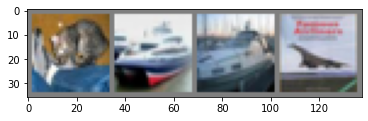

GroundTruth:    cat  ship  ship plane


In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Load model (just for demonstration here).

In [12]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
outputs = net(images)
_, predicted = torch.max(outputs, 1) # predicted is the indices of the max values along axis 1

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


Test on entire test set.

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for batch in testloader:
        images, labels = batch
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # Just a complicated way to get the number of items per batch
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


Performance on each class.

In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for batch in testloader:
        images, labels = batch
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 63 %
Accuracy of  bird : 34 %
Accuracy of   cat : 38 %
Accuracy of  deer : 64 %
Accuracy of   dog : 39 %
Accuracy of  frog : 56 %
Accuracy of horse : 63 %
Accuracy of  ship : 61 %
Accuracy of truck : 64 %


## Training on GPU

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


When called on a `nn.Module`-inheriting object, the `to` method will go over all modules and convert their parameters and buffers to CUDA tensors.

In [31]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

You also need to send the inputs and targets at every step to the GPU.

In [32]:
inputs, labels = batch[0].to(device), batch[1].to(device)